# Prevendo gastos em saúde com modelo de regressão linear<br>
(https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/linear-regression-health-costs-calculator)

Desafio encontrado no freecodecamp, com objetivo principal de usar modelo de regressão linear para prever gastos em saúde. Foram feitas análises exploratorias e um esboço de analise preditiva com modelos de regressão linear. Como curiosidade e para fins de também foram implementados outros modelos de preditivos e investigação mais aprofundada de variáveis.

- Objetivo: utilizar modelo de regressão linear para prever de gastos em dolares em saúde da amostra

- Erro médio absoluto (média dos erros entre valores preditos e valores reais) deve ser menor ou igual a 3500

Qualquer sugestões e criticas construtivas são muito bem vindas.

# 1.Importando bibliotecas

In [9]:
import time

# Análise e visualização de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, LabelEncoder

# Modelos e métricas
import shap
from sklearn import metrics
from sklearn.svm import SVR
from keras.layers import Dense
from keras.models import Sequential
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, SGDRegressor

# Otimização de modelo
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel 
from sklearn.feature_selection import f_regression, mutual_info_regression

# Estilo de gráficos
plt.style.use('ggplot')

# Formatar saidas de tabelas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2.Importando dataset e informações gerais

In [2]:
df = pd.read_csv('data/gastos_saude.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.sample(10)

,age,sex,bmi,children,smoker,region,expenses
718,51,female,36.700,2,no,northwest,10848.130
355,46,male,27.600,0,no,southwest,24603.050
569,48,male,40.600,2,yes,northwest,45702.020
266,40,male,19.800,1,yes,southeast,17179.520
814,36,male,34.400,2,no,southeast,5584.310
717,60,male,24.300,1,no,northwest,13112.600
1225,33,female,39.800,1,no,southeast,4795.660
614,20,female,33.000,0,no,southeast,1880.070
851,61,male,32.300,2,no,northwest,14119.620
407,47,female,23.600,1,no,southwest,8539.670


# 3.Análise descritiva

## Univariada

### Features numéricas

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.000,39.207,14.050,18.000,27.000,39.000,51.000,64.000
bmi,1338.000,30.665,6.098,16.000,26.300,30.400,34.700,53.100
children,1338.000,1.095,1.205,0.000,0.000,1.000,2.000,5.000
expenses,1338.000,13270.422,12110.011,1121.870,4740.288,9382.030,16639.915,63770.430


Podemos observar alguns detalhes iniciais:
- A idade possui média e mediana proxima, indicando que possivelmente não há outliers desequilibrando as métricas e os intervalos dos quartis estão relativamente equilibrados<br>
<br>
- O imc aparentemente tem distribuição normal, e também esta balanceado quantos aos intervalos dos quartis, assim como média e medianas proximas. Aparentemente possui alguns valores extremos maximo. Teremos que confirmar nos gráficos.<br>
<br>
- O número de filhos mostra que 75% das pessoas tem até 2 filhos (terceiro quartil) ou seja, um número reduzido de pessoas tem mais que dois filhos.<br>
<br>
- Já para o valor gasto temos provavelmente uma distribuição assimétrica e com valores extremos, pois temos 75% das observações com até 16mil de gastos, e o valor máximo chega a quase 4 vezes mais. Isso pode também ser notado pelos valores de média e mediana, respectivamente por volta de 13mil e 9mil. Confirmaremos também nos gráficos.

In [7]:
# Selecionando colunas com variáveis numéricas
num_col = df.select_dtypes(include='number').columns

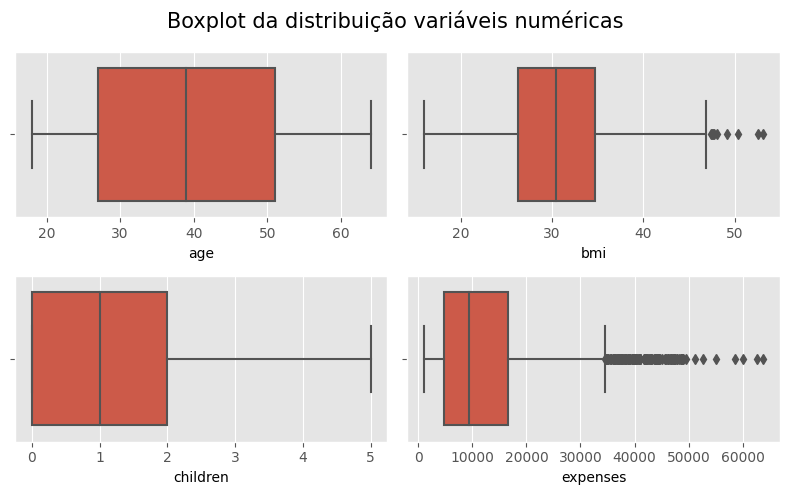

In [10]:
# Definindo tamanho da figura
plt.figure(figsize=(8,5))

# Título
plt.suptitle('Boxplot da distribuição variáveis numéricas', fontsize=15)

# Iterando pela lista de variáveis numéricas e plotando os subplots
for num, item in enumerate(num_col):
    plt.subplot(2, 2, num+1)
    sns.boxplot(data = df, x = item)
    
plt.tight_layout()

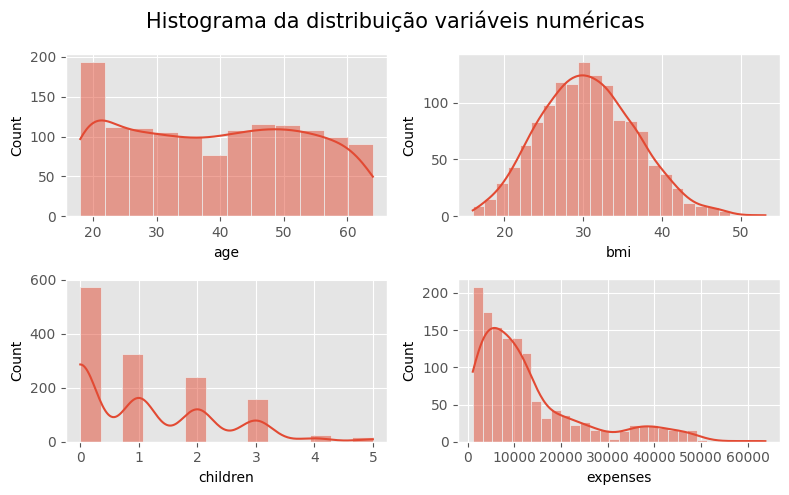

In [18]:
# Definindo tamanho da figura
plt.figure(figsize=(8,5))

# Título
plt.suptitle('Histograma da distribuição variáveis numéricas', fontsize=15)

# Iterando pela lista de variáveis numéricas e plotando os subplots
for num, item in enumerate(num_col):
    plt.subplot(2, 2, num+1)
    sns.histplot(data = df, x = item, kde = True)
plt.tight_layout()

Pelos gráficos confirmamos as suspeitas levantadas inicialmente. Os valores de imc tem distribuição normal, ou próximo, há predomínio de pessoas com até 2 filhos, e os gastos tem distribuição não normal (assimetria positiva, valores predominantes são os mais baixos) com alguns outliers nos maiores valores. Podemos observar que há um equilíbrio na idade dos participantes, com uma quatidade elevada de pessoas mais jovens, proxima dos 20 anos

### Features categóricas

In [ ]:
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [8]:
# Selecionando variáveis categóricas
cat_col = df.select_dtypes(include='object').columns

In [14]:
# Verificando valores por categorias iterando sobre a lista de variáveis categóricas
for item in cat_col:
    print(df[item].value_counts().to_frame().T)
    print("="*50)

     male  female
sex   676     662
          no  yes
smoker  1064  274
        southeast  southwest  northwest  northeast
region        364        325        325        324


C:\Users\55199\AppData\Local\Temp\ipykernel_2648\818669282.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, num+1)


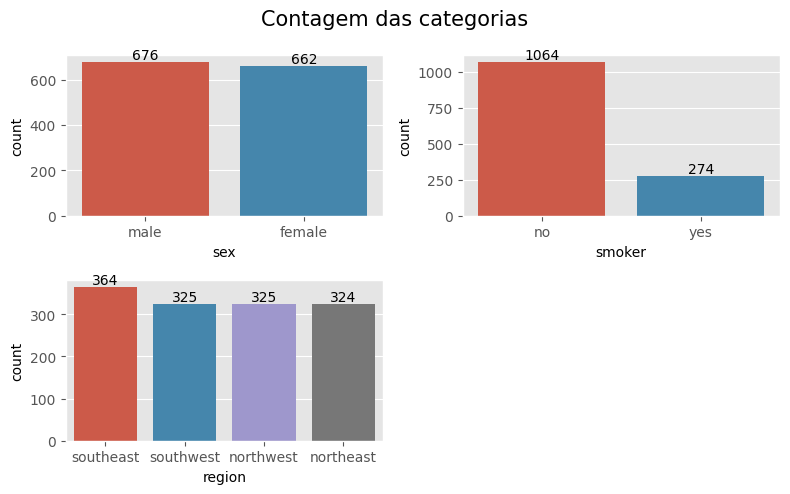

In [24]:
# Definindo tamanho e título
plt.subplots(figsize=(8, 5))
plt.suptitle('Contagem das categorias', fontsize=15)

# Iterando sobre lista de variáveis categóricas e plotando subplots
for num, item in enumerate(cat_col):
    plt.subplot(2, 2, num+1)
    ax = sns.countplot(data=df, x=item, order=df[item].value_counts().index)
    ax.bar_label(ax.containers[0])
    # ax.set_yticks([])
    # ax.set(ylabel='')

plt.tight_layout()

Observamos que não há desequilíbrio em relação ao gênero/sexo, e quanto a região em que os participantes da amostra moram. Porém em relação ao tabagistmo observamos que não fumantes e fumantes estão em uma proporção de quase 4:1. Investigaremos mais a fundo esses diferenças mais a frente nas análises bi e multivariadas.

## Bivariada

Para análise bivairada usaremos a função groupby, que separa o dataset de acordo com a váriavel de interesse. Isso facilita avaliarmos as características das variáveis dentro de determinados grupos.

### Features numéricas x numéricas

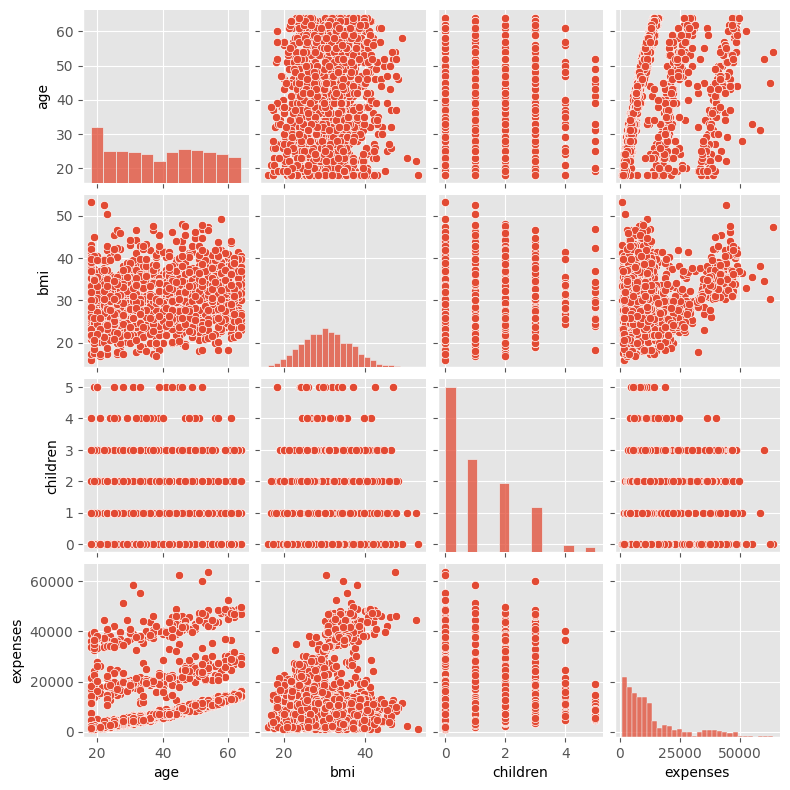

In [37]:
sns.pairplot(df, height=2)

Pela visualização da ultima linha do pairplot (comparação entre 2 variáveis numéricas) podemos observar que, para a vaiável de interesse "expenses" possivelmente há alguma interação com idade e imc, pois conseguimos identificar alguns padrões para essas duas outras variáveis, sendo uma correlação positiva com imc e algumas faixas de valores de gasto com a idade.<br>
<br>Essa informação tem alguma fundamentação na literatura, pois há indícios de aumento de gastos com a idade e em alguns casos e cenários proporção diretamente proporcional de gastos com imc.

### Features categóricas x numéricas

#### Sexo

In [40]:
df.groupby('sex')['age'].describe().T

sex,female,male
count,662.000000,676.000000
mean,39.503021,38.917160
std,14.054223,14.050141
min,18.000000,18.000000
25%,27.000000,26.000000
50%,40.000000,39.000000
75%,51.750000,51.000000
max,64.000000,64.000000


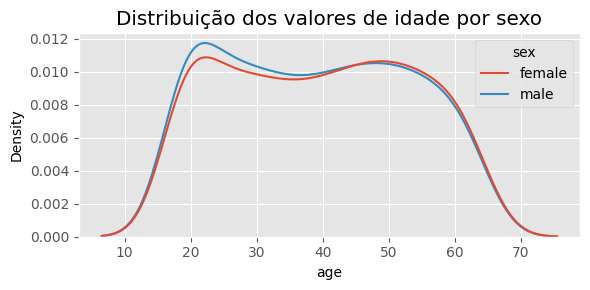

In [50]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'age', hue = 'sex')

plt.title('Distribuição dos valores de idade por sexo')

plt.tight_layout()

In [41]:
df.groupby('sex')['bmi'].describe().T

sex,female,male
count,662.000000,676.000000
mean,30.379758,30.945266
std,6.046508,6.140346
min,16.800000,16.000000
25%,26.100000,26.400000
50%,30.100000,30.700000
75%,34.300000,35.025000
max,48.100000,53.100000


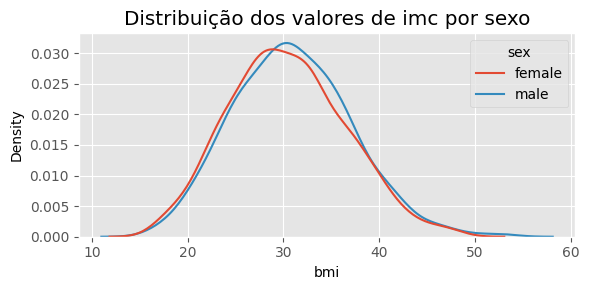

In [51]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'bmi', hue = 'sex')

plt.title('Distribuição dos valores de imc por sexo')

plt.tight_layout()

In [54]:
df.groupby('sex')['expenses'].describe().T

sex,female,male
count,662.000000,676.000000
mean,12569.578897,13956.751420
std,11128.703817,12971.025897
min,1607.510000,1121.870000
25%,4885.162500,4619.135000
50%,9412.965000,9369.615000
75%,14454.690000,18989.595000
max,63770.430000,62592.870000


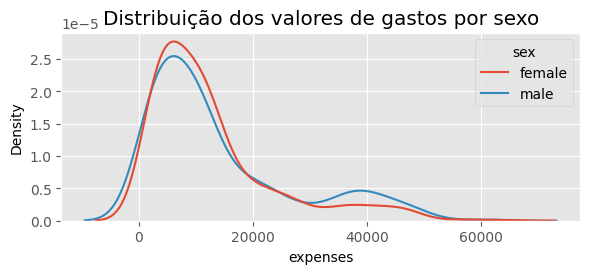

In [143]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'expenses', hue = 'sex')

plt.title('Distribuição dos valores de gastos por sexo')

plt.tight_layout()

In [55]:
df.groupby('sex')['children'].describe().T

sex,female,male
count,662.000000,676.000000
mean,1.074018,1.115385
std,1.192115,1.218986
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,5.000000,5.000000


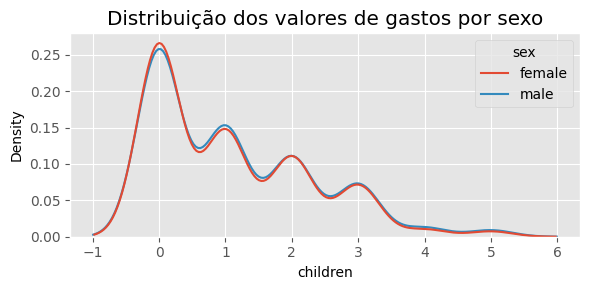

In [56]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'children', hue = 'sex')

plt.title('Distribuição dos valores de gastos por sexo')

plt.tight_layout()

#### Tabagismo

In [57]:
df.groupby('smoker')['age'].describe().T

smoker,no,yes
count,1064.000000,274.000000
mean,39.385338,38.514599
std,14.083410,13.923186
min,18.000000,18.000000
25%,26.750000,27.000000
50%,40.000000,38.000000
75%,52.000000,49.000000
max,64.000000,64.000000


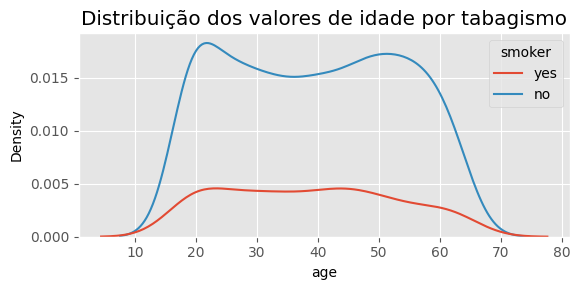

In [59]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'age', hue = 'smoker')

plt.title('Distribuição dos valores de idade por tabagismo')

plt.tight_layout()

In [60]:
df.groupby('smoker')['bmi'].describe().T

smoker,no,yes
count,1064.000000,274.000000
mean,30.653195,30.713139
std,6.042763,6.320840
min,16.000000,17.200000
25%,26.300000,26.100000
50%,30.350000,30.450000
75%,34.400000,35.200000
max,53.100000,52.600000


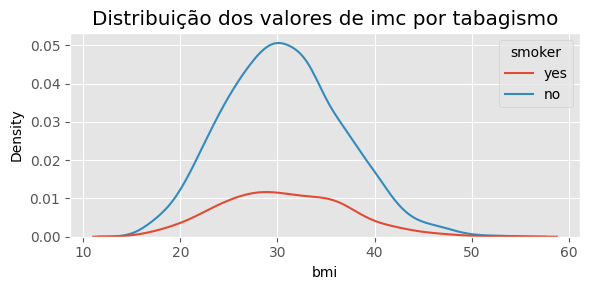

In [61]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'bmi', hue = 'smoker')

plt.title('Distribuição dos valores de imc por tabagismo')

plt.tight_layout()

In [62]:
df.groupby('smoker')['expenses'].describe().T

smoker,no,yes
count,1064.000000,274.000000
mean,8434.268449,32050.231971
std,5993.781756,11541.547338
min,1121.870000,12829.460000
25%,3986.442500,20826.245000
50%,7345.405000,34456.350000
75%,11362.890000,41019.205000
max,36910.610000,63770.430000


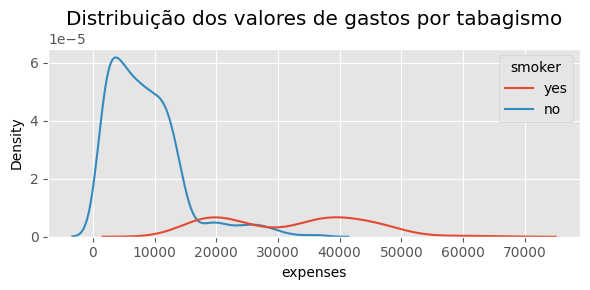

In [63]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'expenses', hue = 'smoker')

plt.title('Distribuição dos valores de gastos por tabagismo')

plt.tight_layout()

In [73]:
df.groupby('smoker')['children'].describe().T

smoker,no,yes
count,1064.000000,274.000000
mean,1.090226,1.113139
std,1.218136,1.157066
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,5.000000,5.000000


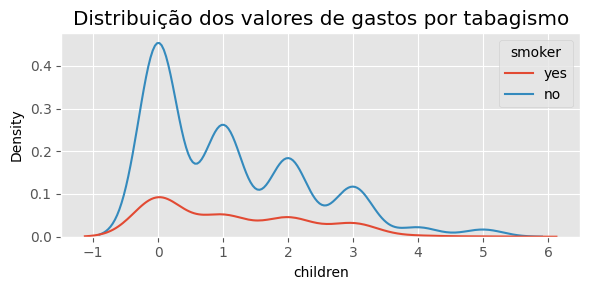

In [74]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'children', hue = 'smoker')

plt.title('Distribuição dos valores de gastos por tabagismo')

plt.tight_layout()

#### Região

In [64]:
df.groupby('region')['age'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000000,325.000000,364.000000,325.000000
mean,39.268519,39.196923,38.939560,39.455385
std,14.069007,14.051646,14.164585,13.959886
min,18.000000,19.000000,18.000000,19.000000
25%,27.000000,26.000000,26.750000,27.000000
50%,39.500000,39.000000,39.000000,39.000000
75%,51.000000,51.000000,51.000000,51.000000
max,64.000000,64.000000,64.000000,64.000000


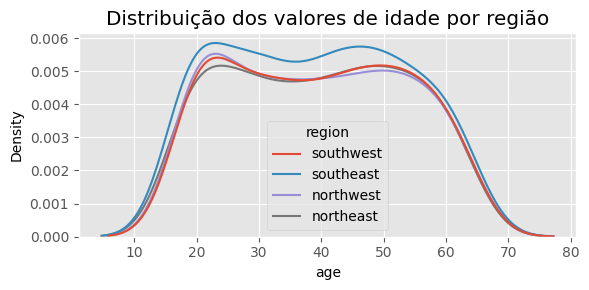

In [65]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'age', hue = 'region')

plt.title('Distribuição dos valores de idade por região')

plt.tight_layout()

In [66]:
df.groupby('region')['bmi'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000000,325.000000,364.000000,325.000000
mean,29.176235,29.201846,33.359341,30.596615
std,5.936847,5.136140,6.478891,5.691836
min,16.000000,17.400000,19.800000,17.400000
25%,24.875000,25.700000,28.575000,26.900000
50%,28.900000,28.900000,33.300000,30.300000
75%,32.925000,32.800000,37.800000,34.600000
max,48.100000,42.900000,53.100000,47.600000


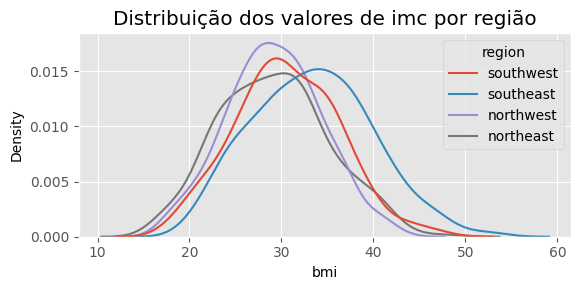

In [67]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'bmi', hue = 'region')

plt.title('Distribuição dos valores de imc por região')

plt.tight_layout()

In [69]:
df.groupby('region')['expenses'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000000,325.000000,364.000000,325.000000
mean,13406.384691,12417.575169,14735.411538,12346.937908
std,11255.802916,11072.276880,13971.098797,11557.179033
min,1694.800000,1621.340000,1121.870000,1241.570000
25%,5194.322500,4719.740000,4440.885000,4751.070000
50%,10057.655000,8965.800000,9294.130000,8798.590000
75%,16687.365000,14711.740000,19526.287500,13462.520000
max,58571.070000,60021.400000,63770.430000,52590.830000


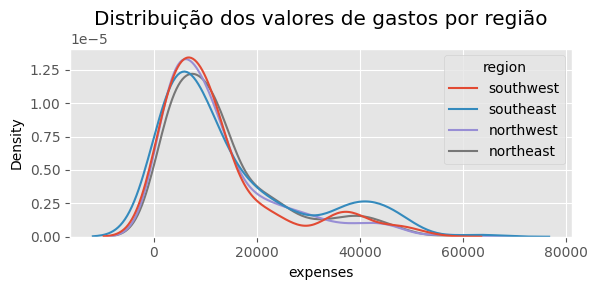

In [70]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'expenses', hue = 'region')

plt.title('Distribuição dos valores de gastos por região')

plt.tight_layout()

In [71]:
df.groupby('region')['children'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000000,325.000000,364.000000,325.000000
mean,1.046296,1.147692,1.049451,1.141538
std,1.198949,1.171828,1.177276,1.275952
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000


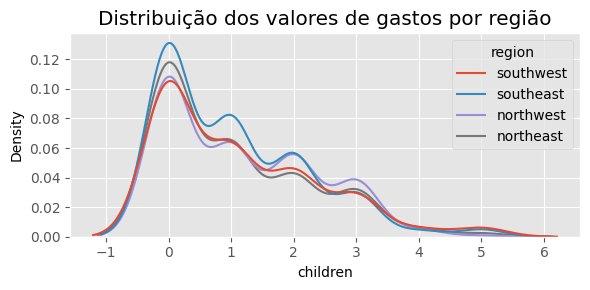

In [72]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'children', hue = 'region')

plt.title('Distribuição dos valores de gastos por região')

plt.tight_layout()

In [113]:
df.groupby('sex')['expenses'].describe().T

sex,female,male
count,662.000000,676.000000
mean,12569.578897,13956.751420
std,11128.703817,12971.025897
min,1607.510000,1121.870000
25%,4885.162500,4619.135000
50%,9412.965000,9369.615000
75%,14454.690000,18989.595000
max,63770.430000,62592.870000


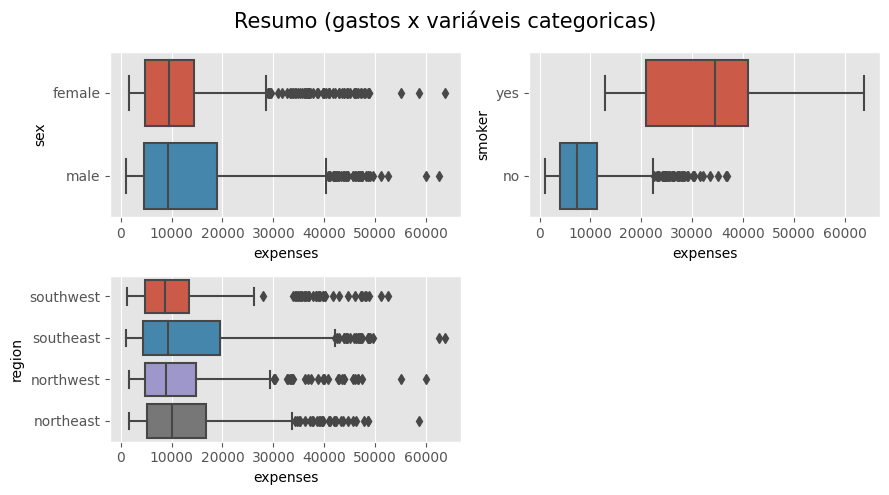

In [79]:
plt.figure(figsize=(9,5))
plt.suptitle('Resumo (gastos x variáveis categoricas)', fontsize=15)

for num, item in enumerate(cat_col):
    plt.subplot(2, 2, num+1)
    sns.boxplot(data=df, x='expenses', y=item)

plt.tight_layout()

Para as variáveis numéricas temos uma sobreposição das distribuições com todas as variáveis categóricas.<br>
<br>
Isso ocorre exceto quando avaliamos se a pessoa é tabagista ou não e os gastos que teve em saúde. Nesse caso podemos observar que a distribuição dos valores de quem não é tabagista é assimétrica positivamente, se concentrando nos valores mais baixos, enquanto que para os fumantes os valores para gastos estão em maior número entre 20 a 40mil, chegando até a 60mil. Há também uma discrepancia ente valores de média (quase 4 vezes maior para pessoas fumantes) e todos os outros quartis.<br>
<br>
Como já levantado anteriormente um dos fatores que podem influenciar gastos, por estar relacionado com morbidades e comorbidades é o tabagismo, e provavelmente essa feature será imporatante para o nosso modelo.


In [75]:
df.groupby('smoker')['expenses'].describe().T

smoker,no,yes
count,1064.000000,274.000000
mean,8434.268449,32050.231971
std,5993.781756,11541.547338
min,1121.870000,12829.460000
25%,3986.442500,20826.245000
50%,7345.405000,34456.350000
75%,11362.890000,41019.205000
max,36910.610000,63770.430000


### Features categóricas x categóricas

Text(0.5, 0, '')

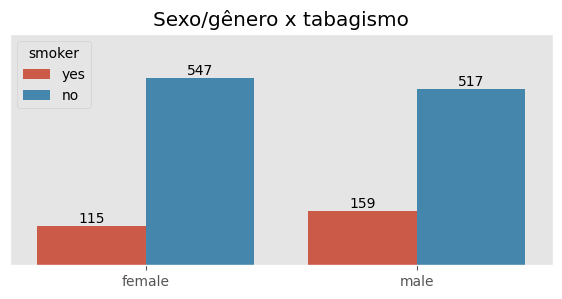

In [101]:
plt.figure(figsize = (7, 3))

ax = sns.countplot(df, x = 'sex', hue = 'smoker')
plt.title('Sexo/gênero x tabagismo')
plt.ylim([0, df['sex'].value_counts().max()])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.yticks([])
plt.ylabel("")
plt.xlabel("")


Text(0.5, 0, '')

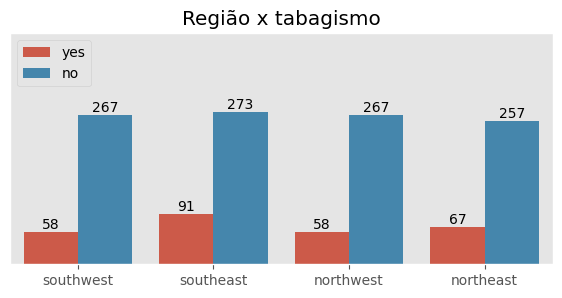

In [102]:
plt.figure(figsize = (7, 3))

ax = sns.countplot(df, x = 'region', hue = 'smoker')
plt.title('Região x tabagismo')
plt.ylim([0, df['region'].value_counts().max() + 50])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.legend(loc = 'upper left')
plt.yticks([])
plt.ylabel("")
plt.xlabel("")


Text(0.5, 0, '')

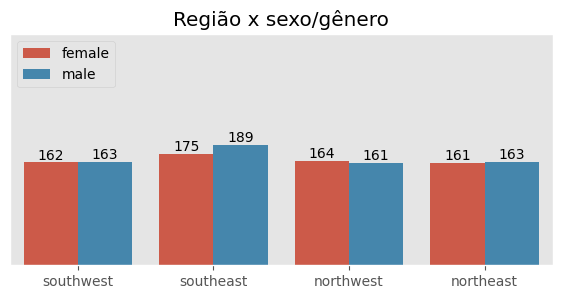

In [104]:
plt.figure(figsize = (7, 3))

ax = sns.countplot(df, x = 'region', hue = 'sex')
plt.title('Região x sexo/gênero')
plt.ylim([0, df['region'].value_counts().max()])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.legend(loc = 'upper left')
plt.yticks([])
plt.ylabel("")
plt.xlabel("")

## Multivariada

Na análise multivariada investigaremos a interação de mais de duas features. Focaremos na análise da feature alvo, "expenses".

### Gastos x imc x features categóricas

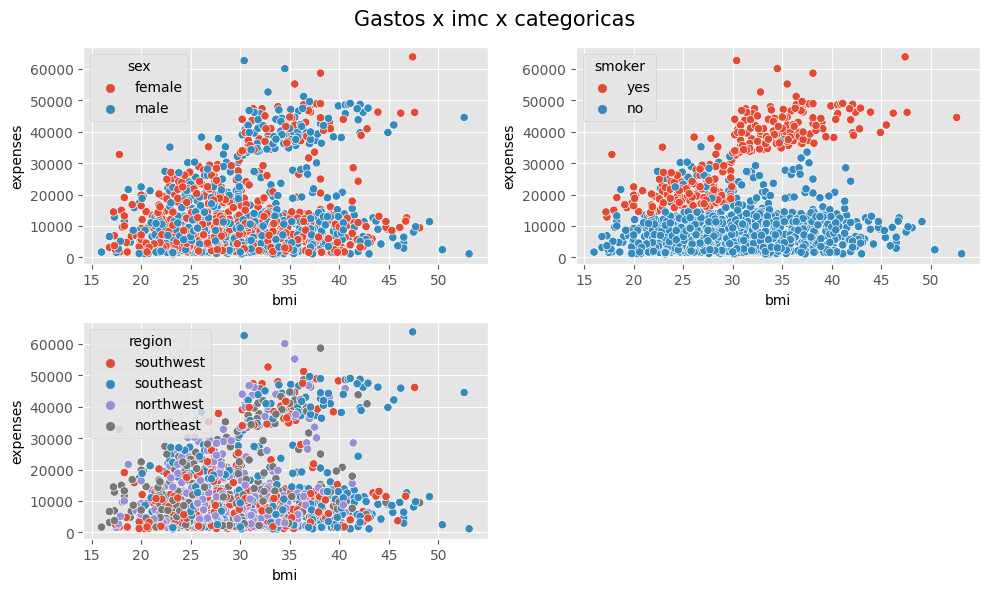

In [107]:
plt.figure(figsize=(10,6))
plt.suptitle('Gastos x imc x categoricas', fontsize=15)

for num, item in enumerate(cat_col):
    plt.subplot(2, 2, num+1)
    sns.scatterplot(data=df, x='bmi', y='expenses', hue=item)

plt.tight_layout()

### Gastos x idade x features categóricas

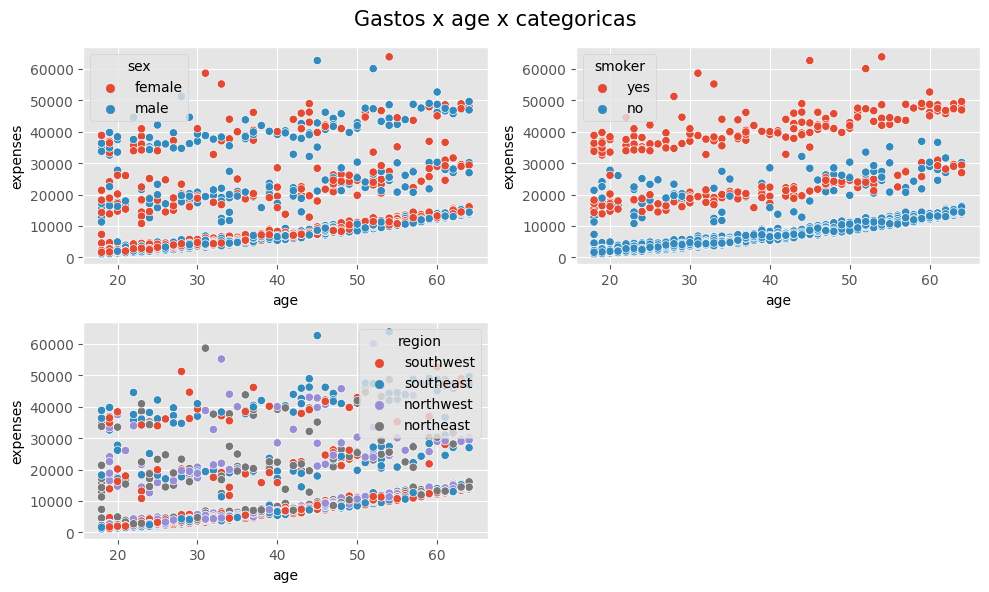

In [108]:
plt.figure(figsize=(10,6))
plt.suptitle('Gastos x age x categoricas', fontsize=15)

for num, item in enumerate(cat_col):
    plt.subplot(2, 2, num+1)
    sns.scatterplot(data=df, x='age', y='expenses', hue=item)

plt.tight_layout()

Observamos pelo gráfico de dispersão que padrões emergem da interação de mais de 2 variáveis (faixas de valores que separam grupos relativamente bem delineados), sendo possível notar que tabagismo, idade e imc podem ser features importantes para prever os gastos.<br>
<br>
Podemos investigar mais a fundo algumas opções, colocando valores de corte para algumas variáveis como a seguir.

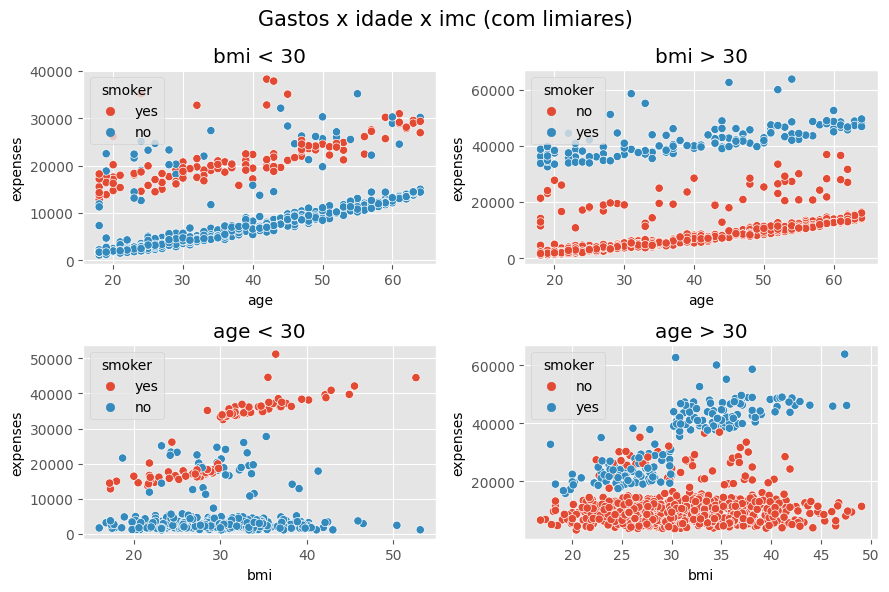

In [111]:
plt.figure(figsize=(9,6))
plt.suptitle('Gastos x idade x imc (com limiares)', fontsize=15)

plt.subplot(2, 2, 1).set_title('bmi < 30')
sns.scatterplot(data=df[df['bmi'] < 30], x='age', y='expenses', hue='smoker')
plt.subplot(2, 2, 2).set_title('bmi > 30')
sns.scatterplot(data=df[df['bmi'] > 30], x='age', y='expenses', hue='smoker')
plt.subplot(2, 2, 3).set_title('age < 30')
sns.scatterplot(data=df[df['age'] < 30], x='bmi', y='expenses', hue='smoker')
plt.subplot(2, 2, 4).set_title('age > 30')
sns.scatterplot(data=df[df['age'] > 30], x='bmi', y='expenses', hue='smoker')


plt.tight_layout()

Quando aplicamos um limiar esses padrões se tornam mais evidentes, com idade e imc > de 30 sendo os que mais segregam as observações.<br>
<br> Para filhos não foi observado nenhuam interação ou padrão relevante.

# 4.Pré-processamento

## Train test split

In [23]:
X = df.drop('expenses', axis=1)

Y = df['expenses']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [4]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

## Transformações e encodings

### Features numéricas

Ao utilizarmos features numéricas devemos nos atentar as escalas em que elas se encontram. O motivo disso é que podemos ter features em escala muito maior do que outras podendo alterar a real influência que a feature tem no modelo. Por exemplo, uma feature mensurando tempo ou moeda podem alcançar a casa dos centenas e dos milhares enquanto que outras, como no nosso exemplo, idade, imc e numero de filhos, chegam no máximo a dezenas, tenho pesos diferentes e estimando uma importancia maior ou menor para o modelo, ocasionando em resultados distorcidos. Com alguns transformadores podemos "forçar" a variáveis a estarem numa mesma escala.<br>
<br>Para contornar essa questão devemos padronizar os valores e para isso usaremos 3 possibilidades:
- MinMaxScaler: transforma todos os valores de uma coluna numa escala entre 0 e 1
- StandardScaler: transforma todos os valores em uma escala em que a média é 0 e desvio padrão 1
- RobustScaler: similar ao standardscaler, porém transforma os valores levando em conta a distancia interquartil

#### MinMaxScaler

In [4]:
x_train_num = x_train.select_dtypes('number')

In [54]:
minmax = MinMaxScaler()

x_train_num_minmax = minmax.fit_transform(x_train_num)

df_num_minmax = pd.DataFrame(x_train_num_minmax, columns = x_train_number.columns)

#### StandardScaler

In [60]:
s_scaler = StandardScaler()

x_train_num_s_scaler = s_scaler.fit_transform(x_train_num)

df_num_s_scaler = pd.DataFrame(x_train_num_s_scaler, columns = x_train_number.columns)

#### RobustScaler

In [61]:
r_scaler = RobustScaler()

x_train_num_r_scaler = r_scaler.fit_transform(x_train_num)

df_num_r_scaler = pd.DataFrame(x_train_num_r_scaler, columns = x_train_number.columns)

#### Visualização das transformações

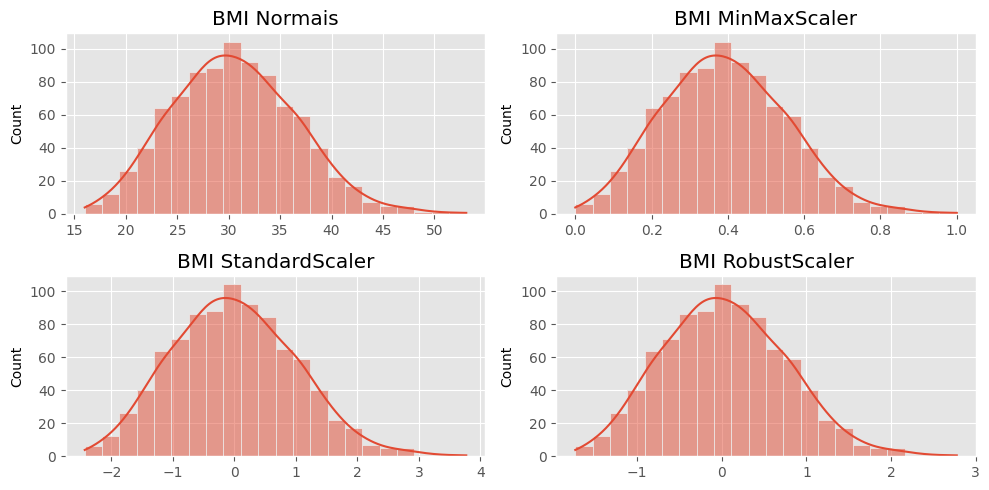

In [77]:
plt.figure(figsize = (10, 5))

plt.subplot(2, 2, 1).set_title('BMI Normais')
sns.histplot(x_train, x = 'bmi', kde = True)
plt.xlabel("")

plt.subplot(2, 2, 2).set_title('BMI MinMaxScaler')
sns.histplot(df_num_minmax, x = 'bmi', kde = True)
plt.xlabel("")

plt.subplot(2, 2, 3).set_title('BMI StandardScaler')
sns.histplot(df_num_s_scaler, x = 'bmi', kde = True)
plt.xlabel("")

plt.subplot(2, 2, 4).set_title('BMI RobustScaler')
sns.histplot(df_num_r_scaler, x = 'bmi', kde = True)
plt.xlabel("")

plt.tight_layout()


As distribuições das 3 transformações tem formato similar ao da features sem nenhum tratamento, porém estão em escalar diferentes.
Nesse desafio usaremos o StandardScaler, pois é mais robusta a presença de outliers, provavelmente tendo menos distorções dos valores.

### Features categóricas

Modelos de machine learning lidam muito bem com números, porém muitas vezes temos que usar features não numéricas para construir modelos. Dessa forma podemos converter nossas variáveis não numéricas em números. O Scikit-Learn disponibiliza muitas opções, as mais usadas são:
- LabelEncoder: converte cada categoria em um número
- OneHotEncoder: cria uma coluna com valores binários para cada categoria, e atribui 0 ou 1 para a ausencia ou presença da categoria
- OrdialEncoder: similar ao LabelEncoder, porém atribui um valor numérico baseado no rank da categoria

Para esse caso usaremos o OneHotEncoder

#### OneHotEncoder

In [83]:
ohe = OneHotEncoder(drop = 'if_binary')

x_train_ohe = ohe.fit_transform(x_train[cat_col])

df_x_train_ohe = pd.DataFrame(x_train_ohe.toarray(), columns = ohe.get_feature_names_out(cat_col))

- Comparando resultado

In [91]:
df_x_train_ohe.head(1)

,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.0,0.0,1.0,0.0,0.0,0.0


In [93]:
x_train[['sex', 'smoker', 'region']].head(1)

,sex,smoker,region
1046,female,no,northeast


## Pipeline

O processo de transformação das features pode conter muitos passos e se torna trabalhoso, principalemnte quando queremos testar diversas abordagens. Para agilizar e facilitar o processo trabalharemos com pipelines, que basicamente são estruturas pré-determinadas pelo usuário com objetivo de executar muitas tarefas de forma sequencial e automatizada.

In [25]:
numericas = x_train.select_dtypes('number').columns
categoricas = x_train.select_dtypes('object').columns

In [10]:
print(numericas)
print(categoricas)

Index(['age', 'bmi', 'children'], dtype='object')
Index(['sex', 'smoker', 'region'], dtype='object')


In [26]:
processador_num_1 = Pipeline([('s_scaler', StandardScaler())])

processador_cat_1 = Pipeline([('ohe', OneHotEncoder(drop = "if_binary"))])

preprocessador_1 = ColumnTransformer(transformers = [
    ("processador_num_1", processador_num_1, numericas),
    ("processador_cat_1", processador_cat_1, categoricas),
    ], remainder = 'passthrough', verbose_feature_names_out=False)

In [27]:
preprocessador_1

ColumnTransformer(remainder='passthrough',
                  transformers=[('processador_num_1',
                                 Pipeline(steps=[('s_scaler',
                                                  StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('processador_cat_1',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))],
                  verbose_feature_names_out=False)

In [28]:
x_train_preproc = pd.DataFrame(preprocessador_1.fit_transform(x_train),
                               columns = preprocessador_1.get_feature_names_out())

In [29]:
x_test_preproc = pd.DataFrame(preprocessador_1.transform(x_test),
                               columns = preprocessador_1.get_feature_names_out())

In [15]:
x_train_preproc.head(5).T

,0,1,2,3,4
age,0.265,-0.017,0.406,-1.425,1.462
bmi,-0.910,0.795,-0.008,0.394,1.564
children,-0.913,0.748,-0.082,-0.913,-0.913
sex_male,0.000,1.000,0.000,0.000,1.000
smoker_yes,0.000,1.000,1.000,0.000,1.000
region_northeast,1.000,0.000,0.000,0.000,0.000
region_northwest,0.000,0.000,1.000,0.000,0.000
region_southeast,0.000,0.000,0.000,0.000,0.000
region_southwest,0.000,1.000,0.000,1.000,1.000


In [16]:
x_test_preproc.head(5).T

,0,1,2,3,4
age,0.406,-0.228,1.744,0.476,-1.425
bmi,-0.894,-0.091,-0.609,-0.810,0.227
children,0.748,-0.913,-0.913,1.578,-0.913
sex_male,0.000,0.000,0.000,1.000,1.000
smoker_yes,0.000,0.000,1.000,0.000,1.000
region_northeast,1.000,0.000,0.000,0.000,0.000
region_northwest,0.000,1.000,1.000,1.000,1.000
region_southeast,0.000,0.000,0.000,0.000,0.000
region_southwest,0.000,0.000,0.000,0.000,0.000


# 5.Modelagem

## Regressão Linear - Modelo Base

Para fazer previsões de variáveis numéricas o modelo mas simples é a regressão linear, nele analisamos a relação de uma variável reposta (a que queremos prever ou variável dependente) e uma (regressão simples) ou mais variáveis independente (regressão múltipla). No nosso caso a variável reposta é o valor gasto com cuidados em saúde, e eles podem estar sendo diretamente influenciados por caracteristicas dos indivíduos, como peso, idade e IMC, sendo essas as variáveis independentes do nosso problema, ou seja características dos indivíduos.<br>
<br>
O objetivo é encontrar uma linha reta que melhor represente a relação entre as variáveis. Essa linha é chamada de linha de regressão ou reta de ajuste (exemplo abaixo).<br>

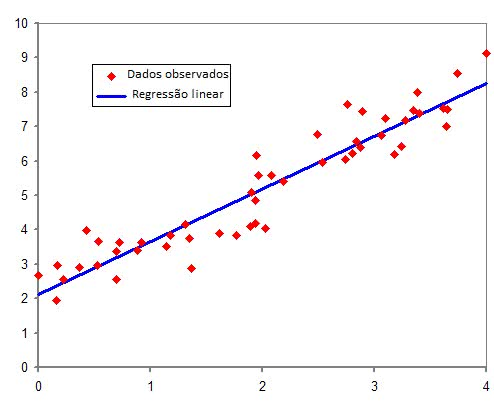

In [1]:
from IPython.display import Image
Image(filename='data/reglin.jpeg')

 Na regressão linear temos a formula abaixo, em que o valor de y (variável dependente ou reeposta)é calculado pelo intercepto (ponto de contato com a linha re regressão com o eixo y) mais o coeficiente beta multiplicado pelo valor da variável x mais o erro. Se tivermos "n" variáveis teremos "n" coeficientes sendo multiplicados por n valores de suas respectivas variáveis. No nosso caso temos que n = 9.

$y = \beta_0 + \beta_1 x + \epsilon$

In [9]:
reglin0_inic = time.time() 

reglin0 = LinearRegression()

reglin0.fit(x_train_preproc, y_train)

y_pred_reglin0 = reglin0.predict(x_test_preproc)

reglin0_fim = time.time()

reglin0_total = reglin0_fim - reglin0_inic

In [10]:
reglin0_intercept = reglin0.intercept_.round(3)
reglin0_score = reglin0.score(x_train_preproc, y_train).round(3)
reglin0_mse = metrics.mean_squared_error(y_test, y_pred_reglin0).round(3)
reglin0_mae = metrics.mean_absolute_error(y_test, y_pred_reglin0).round(3)

print("="*46)
print("Regressão Linear - Modelo Base")
print("="*46)
print(f'Intercepto: {reglin0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, reglin0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {reglin0_score}')
print("-"*46)
print(f'Erro quadrático médio: {reglin0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {reglin0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(reglin0_total, 3)}s')
print("="*46)

Regressão Linear - Modelo Base
Intercepto: 8338.756
----------------------------------------------
Coeficientes
age = 3715.138
bmi = 2076.404
children = 448.085
sex_male = 121.325
smoker_yes = 23700.333
region_northeast = 507.015
region_northwest = 168.044
region_southeast = -379.422
region_southwest = -295.638
----------------------------------------------
R²: 0.746
----------------------------------------------
Erro quadrático médio: 35087527.614
----------------------------------------------
Erro absoluto médio: 4193.042
----------------------------------------------
Tempo de execução: 0.169s


Para o nosso modelo encontramos os valores de coeficiente que adicionados à formula teremos:

$y =  8338.756(intercepto) + 3715.13\times(idade) + 2076.404\times(imc) + 448.085\times(n\_filhos) + 121.325\times(homem) + 23700.333\times(tabagista) + 507.015\times(northeast) + 168.044\times(northwest) - 379.422\times(southeast) - 295.638\times(southwest) + ε$


Nesse caso o MAE foi maior do que o aceitável proposto no desafio.<br>
Vamos experimentar outras alternativas

## Ridge

Com Ridge Regression o objetivo é minimizar o erro quadrático somado a uma penalização da soma dos coeficientes ao quadrado. Isso ajuda a evitar overfitting e reduzir a influência de coeficientes menos relevantes.

In [23]:
ridge0_inic = time.time() 

ridge0 = RidgeCV(cv = 5, alphas = [0.001, 0.01, 0.1, 1, 10, 100])

ridge0.fit(x_train_preproc, y_train)

y_pred_ridge0 = ridge0.predict(x_test_preproc)

ridge0_fim = time.time()

ridge0_total = ridge0_fim - ridge0_inic

In [24]:
ridge0_intercept = ridge0.intercept_.round(3)
ridge0_score = ridge0.score(x_train_preproc, y_train).round(3)
ridge0_mse = metrics.mean_squared_error(y_test, y_pred_ridge0).round(3)
ridge0_mae = metrics.mean_absolute_error(y_test, y_pred_ridge0).round(3)

print("="*46)
print("Ridge Regression")
print("="*46)
print(f'Intercepto: {ridge0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, ridge0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {ridge0_score}')
print("-"*46)
print(f'Erro quadrático médio: {ridge0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {ridge0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(ridge0_total, 3)}s')
print("="*46)

Ridge Regression
Intercepto: 8370.069
----------------------------------------------
Coeficientes
age = 3708.023
bmi = 2072.911
children = 450.294
sex_male = 125.806
smoker_yes = 23540.169
region_northeast = 505.691
region_northwest = 162.558
region_southeast = -373.599
region_southwest = -294.65
----------------------------------------------
R²: 0.746
----------------------------------------------
Erro quadrático médio: 35108760.734
----------------------------------------------
Erro absoluto médio: 4205.321
----------------------------------------------
Tempo de execução: 0.19s


Ainda temos um MAE acima do limite proposto.

## Lasso

Com Lasso Regression o objetivo é minimizar o erro quadrático somado a uma penalização da soma dos valores absolutos dos coeficientes. Isso ajuda a evitar overfitting e a selecionar automaticamente as variáveis mais relevantes.

In [25]:
lasso0_inic = time.time() 

lasso0 = LassoCV()

lasso0.fit(x_train_preproc, y_train)

y_pred_lasso0 = lasso0.predict(x_test_preproc)

lasso0_fim = time.time()

lasso0_total = lasso0_fim - lasso0_inic

In [26]:
lasso0_intercept = lasso0.intercept_.round(3)
lasso0_score = lasso0.score(x_train_preproc, y_train).round(3)
lasso0_mse = metrics.mean_squared_error(y_test, y_pred_lasso0).round(3)
lasso0_mae = metrics.mean_absolute_error(y_test, y_pred_lasso0).round(3)

print("="*46)
print("Lasso Regression")
print("="*46)
print(f'Intercepto: {lasso0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, lasso0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {lasso0_score}')
print("-"*46)
print(f'Erro quadrático médio: {lasso0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {lasso0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(lasso0_total, 3)}s')
print("="*46)

Lasso Regression
Intercepto: 8422.658
----------------------------------------------
Coeficientes
age = 3659.073
bmi = 1941.793
children = 399.603
sex_male = 0.0
smoker_yes = 23283.173
region_northeast = 279.402
region_northwest = 0.0
region_southeast = -0.0
region_southwest = -0.0
----------------------------------------------
R²: 0.745
----------------------------------------------
Erro quadrático médio: 35292510.475
----------------------------------------------
Erro absoluto médio: 4220.97
----------------------------------------------
Tempo de execução: 0.122s


Continuamos com MAE acima do aceitável.

## Elastic Net

Com Elastic Net combinamos a penalização de Ridge e Lasso em uma única regressão, com um parâmetro de mistura que controla o grau de ambas as penalizações. Isso ajuda a lidar com problemas em que há multicolinearidade e muitas variáveis irrelevantes.

In [27]:
enet0_inic = time.time() 

enet0 = ElasticNetCV()

enet0.fit(x_train_preproc, y_train)

y_pred_enet0 = enet0.predict(x_test_preproc)

enet0_fim = time.time()

enet0_total = enet0_fim - enet0_inic

In [28]:
enet0_intercept = enet0.intercept_.round(3)
enet0_score = enet0.score(x_train_preproc, y_train).round(3)
enet0_mse = metrics.mean_squared_error(y_test, y_pred_enet0).round(3)
enet0_mae = metrics.mean_absolute_error(y_test, y_pred_enet0).round(3)

print("="*46)
print("Elastic Net")
print("="*46)
print(f'Intercepto: {enet0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, enet0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {enet0_score}')
print("-"*46)
print(f'Erro quadrático médio: {enet0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {enet0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(enet0_total, 3)}s')
print("="*46)

Elastic Net
Intercepto: 13152.495
----------------------------------------------
Coeficientes
age = 709.429
bmi = 449.066
children = 198.197
sex_male = 49.043
smoker_yes = 961.13
region_northeast = 18.216
region_northwest = -39.856
region_southeast = 34.116
region_southwest = -12.475
----------------------------------------------
R²: 0.095
----------------------------------------------
Erro quadrático médio: 132046247.301
----------------------------------------------
Erro absoluto médio: 8838.568
----------------------------------------------
Tempo de execução: 0.056s


Como resultado temos um MAE muito acima do aceitável. Devemos talvez investigar otimização de hiperparametros dos 3 modelos anteriores.

## Gradiente Descendente

Com gradiente descendente queremos minimizar a função de perda (como o erro quadrático) usando o método de gradiente descendente, que ajusta os coeficientes iterativamente para minimizar a função de perda. A versão estocástica usa amostras aleatórias do conjunto de treinamento para atualizar os coeficientes, o que torna o processo mais rápido e escalável para conjuntos de dados grandes.

In [40]:
sgdr0_inic = time.time() 

sgdr0 = SGDRegressor()

sgdr0.fit(x_train_preproc, y_train)

y_pred_sgdr0 = sgdr0.predict(x_test_preproc)

sgdr0_fim = time.time()

sgdr0_total = sgdr0_fim - sgdr0_inic

In [41]:
sgdr0_intercept = sgdr0.intercept_.round(3)
sgdr0_score = sgdr0.score(x_train_preproc, y_train).round(3)
sgdr0_mse = metrics.mean_squared_error(y_test, y_pred_sgdr0).round(3)
sgdr0_mae = metrics.mean_absolute_error(y_test, y_pred_sgdr0).round(3)

print("="*46)
print("Gradiente Descendente")
print("="*46)
print(f'Intercepto: {sgdr0_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, sgdr0.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {sgdr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {sgdr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {sgdr0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(sgdr0_total, 3)}s')
print("="*46)

Gradiente Descendente
Intercepto: [6669.646]
----------------------------------------------
Coeficientes
age = 3723.653
bmi = 2069.493
children = 462.542
sex_male = 100.974
smoker_yes = 23595.521
region_northeast = 2165.684
region_northwest = 1822.656
region_southeast = 1287.944
region_southwest = 1368.799
----------------------------------------------
R²: 0.746
----------------------------------------------
Erro quadrático médio: 35087557.945
----------------------------------------------
Erro absoluto médio: 4189.484
----------------------------------------------
Tempo de execução: 0.013s


Temos um modelo que performa discretamente melhor do que os anteriores, mas ainda acima do aceitável.

## Decision Tree Regressor

Usando Decision Tree Regressor dividimos recursivamente os dados em subconjuntos com base em variáveis e valores de corte que maximizam a pureza dos subconjuntos em relação à variável de destino. Isso cria uma estrutura de árvore de decisão que pode ser usada para prever a variável de destino para novos dados.

In [73]:
treeregr0_inic = time.time() 

treeregr0 = DecisionTreeRegressor(max_depth=3)

treeregr0.fit(x_train_preproc, y_train)

y_pred_treeregr0 = treeregr0.predict(x_test_preproc)

treeregr0_fim = time.time()

treeregr0_total = treeregr0_fim - treeregr0_inic

In [74]:
# treeregr0_intercept = treeregr0.intercept_.round(3)
treeregr0_score = treeregr0.score(x_train_preproc, y_train).round(3)
treeregr0_mse = metrics.mean_squared_error(y_test, y_pred_treeregr0).round(3)
treeregr0_mae = metrics.mean_absolute_error(y_test, y_pred_treeregr0).round(3)

print("="*46)
print("Decision Tree Regressor")
print("="*46)
print(f'R²: {treeregr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {treeregr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {treeregr0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(treeregr0_total, 3)}s')
print("="*46)

Decision Tree Regressor
R²: 0.859
----------------------------------------------
Erro quadrático médio: 24288654.491
----------------------------------------------
Erro absoluto médio: 2933.291
----------------------------------------------
Tempo de execução: 0.006s


Sendo um modelo mais complexo já podemos observar MAE abaixo do limite estabelecido.

## Random Forest Regressor

Nesse caso criamos um conjunto de árvores de decisão usando amostras aleatórias do conjunto de treinamento e variáveis aleatórias para dividir os nós da árvore. Isso ajuda a reduzir a variância e o overfitting em comparação com uma única árvore de decisão.

In [75]:
rndr0_inic = time.time() 

rndr0 = RandomForestRegressor(max_depth=5)

rndr0.fit(x_train_preproc, y_train)

y_pred_rndr0 = rndr0.predict(x_test_preproc)

rndr0_fim = time.time()

rndr0_total = rndr0_fim - rndr0_inic

In [77]:
# rndr0_intercept = rndr0.intercept_.round(3)
rndr0_score = rndr0.score(x_train_preproc, y_train).round(3)
rndr0_mse = metrics.mean_squared_error(y_test, y_pred_rndr0).round(3)
rndr0_mae = metrics.mean_absolute_error(y_test, y_pred_rndr0).round(3)

print("="*46)
print("Random Forest Regressor")
print("="*46)
print(f'R²: {rndr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {rndr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {rndr0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(rndr0_total, 3)}s')
print("="*46)

Random Forest Regressor
R²: 0.892
----------------------------------------------
Erro quadrático médio: 20546553.439
----------------------------------------------
Erro absoluto médio: 2583.612
----------------------------------------------
Tempo de execução: 0.22s


Com random forest também observamos resultados melhores.

## Gradient Boosting Regressor

Nesse modelo é criado conjunto de árvores de decisão que sejam ajustadas iterativamente aos resíduos da árvore anterior, minimizando a função de perda (como o erro quadrático). Isso ajuda a melhorar a precisão da previsão e a reduzir o overfitting.

In [78]:
gbr0_inic = time.time() 

gbr0 = GradientBoostingRegressor()

gbr0.fit(x_train_preproc, y_train)

y_pred_gbr0 = gbr0.predict(x_test_preproc)

gbr0_fim = time.time()

gbr0_total = gbr0_fim - gbr0_inic

In [81]:
# gbr0_intercept = gbr0.intercept_.round(3)
gbr0_score = gbr0.score(x_train_preproc, y_train).round(3)
gbr0_mse = metrics.mean_squared_error(y_test, y_pred_gbr0).round(3)
gbr0_mae = metrics.mean_absolute_error(y_test, y_pred_gbr0).round(3)

print("="*46)
print("Gradient Boost Regressor")
print("="*46)
print(f'R²: {gbr0_score}')
print("-"*46)
print(f'Erro quadrático médio: {gbr0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {gbr0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(gbr0_total, 3)}s')
print("="*46)

Gradient Boost Regressor
R²: 0.906
----------------------------------------------
Erro quadrático médio: 20617497.3
----------------------------------------------
Erro absoluto médio: 2503.906
----------------------------------------------
Tempo de execução: 0.122s


Temos até agora o melhor modelo.

## Multilayer Perceptron (MLP) - SKLEARN

Aqui estamos lidando com um modelo estremamente poderoso, baseado em redes neurais, no qual o objetivo é criar uma rede neural artificial com várias camadas de neurônios interconectados, com o objetivo de prever uma variável de destino. Cada camada usa uma função de ativação para transformar a entrada em uma saída e a saída é propagada para a próxima camada. O MLP usa backpropagation para ajustar os pesos da rede para minimizar a função de perda (como o erro quadrático).

In [89]:
mlp0_inic = time.time() 

mlp0 = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

mlp0.fit(x_train_preproc, y_train)

y_pred_mlp0 = mlp0.predict(x_test_preproc)

mlp0_fim = time.time()

mlp0_total = mlp0_fim - mlp0_inic

In [90]:
# mlp0_intercept = mlp0.intercept_.round(3)
mlp0_score = mlp0.score(x_train_preproc, y_train).round(3)
mlp0_mse = metrics.mean_squared_error(y_test, y_pred_mlp0).round(3)
mlp0_mae = metrics.mean_absolute_error(y_test, y_pred_mlp0).round(3)

print("="*46)
print("Multilayer Perceptron - SKLEARN")
print("="*46)
print(f'R²: {mlp0_score}')
print("-"*46)
print(f'Erro quadrático médio: {mlp0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {mlp0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(mlp0_total, 3)}s')
print("="*46)

Multi-Layer Perceptron
R²: 0.79
----------------------------------------------
Erro quadrático médio: 28270950.373
----------------------------------------------
Erro absoluto médio: 3409.096
----------------------------------------------
Tempo de execução: 7.003s


Mesmo um modelo básico sem muitos ajustes ja nos da um resultado dentro dos limites estipulados.

## Radial Basis Function (RBF)

Temos aqui outro modelo utilizando redes neurais no qual o objetivo é criar uma rede neural artificial que usa funções de base radial para transformar as entradas em uma saída. As funções de base radial são centradas em pontos específicos no espaço de entrada e usam a distância Euclidiana entre os pontos de entrada e o centro para determinar a saída da função. A rede usa backpropagation para ajustar os pesos da rede para minimizar a função de perda (como o erro quadrático).

In [93]:
rbf0_inic = time.time() 

rbf0 = KernelRidge(kernel='rbf')

rbf0.fit(x_train_preproc, y_train)

y_pred_rbf0 = rbf0.predict(x_test_preproc)

rbf0_fim = time.time()

rbf0_total = rbf0_fim - rbf0_inic

In [94]:
# rbf0_intercept = rbf0.intercept_.round(3)
rbf0_score = rbf0.score(x_train_preproc, y_train).round(3)
rbf0_mse = metrics.mean_squared_error(y_test, y_pred_rbf0).round(3)
rbf0_mae = metrics.mean_absolute_error(y_test, y_pred_rbf0).round(3)

print("="*46)
print("Radial Basis Function")
print("="*46)
print(f'R²: {rbf0_score}')
print("-"*46)
print(f'Erro quadrático médio: {rbf0_mse}')
print("-"*46)
print(f'Erro absoluto médio: {rbf0_mae}')
print("-"*46)
print(f'Tempo de execução: {round(rbf0_total, 3)}s')
print("="*46)

Radial Basis Function
R²: 0.838
----------------------------------------------
Erro quadrático médio: 25994047.101
----------------------------------------------
Erro absoluto médio: 3117.2
----------------------------------------------
Tempo de execução: 0.234s


Também temos um resultado adequado mesmo com um modelo sem ajuste de hiperparametros.

## Features influentes

Nosso modelo inicial obteve algumas métricas interessantes já de início, porém temos muitas features sendo utilizadas para fazer as previsões.<br>
Quanto mais features no modelo mais complexo ele fica e possívelmente algumas estão contribuindo muito pouco ou até atrapalhando o nosso modelo para fazer melhores previsões, aumentando também o tempo de execução.<br>
Sendo assim tentaremos filtrar as variáveis mais importantes e as menos (ou nada) importantes para diminuirmos ruidos, construirmos um modelo mais eficiente, preciso e robusto.

Podemos utilizar alguns tipos de técnicas para selecionar as melhores variáveis para o nosso modelo:
- Filter (testes estatisticos para avaliar relação das features com target)
    - Coeficiente de correlação
    - SelectKBest
    - SelectFromModel
    - Mutual information
    - Teste Chi Quadrado<br>
    <br>
- Wrappper (métodos baseados em performance de modelos treinados com diferentes combinações de variáveis)
    - RFE
    - Foward/backward feature selection<br>
    <br>
- Embedded (combinação de seleção de variáveis com treino de modelos)
    - Lasso
    - Ridge
    - Elastic Net<br>
    <br>
- Dimensionality reduction
    - PCA
    - LDA
    - t-SNE

### SelectKBest

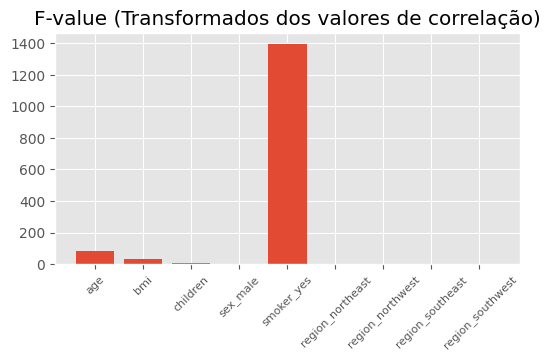

In [26]:
f_selector_1 = SelectKBest(score_func=f_regression, k = 'all')

f_selector_1.fit(x_train_preproc, y_train)

x_test_f_selector_1 = f_selector_1.transform(x_test_preproc)

col_names = x_train_preproc.columns

plt.figure(figsize = (6, 3))
ax = plt.bar([i for i in range(len(f_selector_1.scores_))], f_selector_1.scores_)
plt.xlabel("")
plt.xticks(range(len(col_names)), col_names, fontsize=8, rotation = 45)
plt.title("F-value (Transformados dos valores de correlação)")
plt.show()

Variáveis mais influentes com SelectKBest - f_regresssion:
- tabagismo
- idade
- imc

### Mutual Information

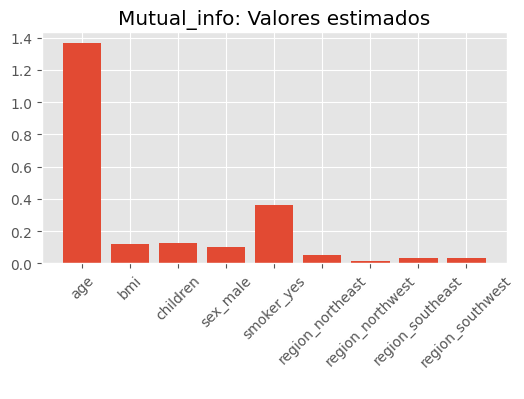

In [25]:
f_selector_2 = SelectKBest(score_func = mutual_info_regression, k = 'all')

f_selector_2.fit(x_train_preproc, y_train)

x_test_f_selector_2 = f_selector_2.transform(x_test_preproc)

col_names = x_train_preproc.columns

mask = f_selector_2.get_support()          # "mascara" para as features selecionadas
selected_features = x_train_preproc.columns[mask]  # index para colunas originais usando a mascara

plt.figure(figsize=(6,3))
plt.bar(selected_features, f_selector_2.scores_[mask])
plt.xticks(rotation=45)
plt.xlabel(" ")
plt.title("Mutual_info: Valores estimados")
plt.show()

Variáveis mais influentes com SelectKBest - mutual_info_regresssion:
- idade
- tabagismo
- n_filhos e imc

### SelectFromModel

In [19]:
reglin_sfm = SelectFromModel(reglin0, prefit = True)

x_train_preproc_reglin_sfm = reglin_sfm.transform(x_train_preproc)

reglin_sfm_features = x_train_preproc.columns[reglin_sfm.get_support()]

print("="*65)
print(f"Variáveis selecionadas com SelectFromModel: {list(reglin_sfm_features)}")
print("="*65)

Variáveis selecionadas com SelectFromModel: ['age', 'smoker_yes']


d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### RFE

In [20]:
reglin0_rfe = RFE(estimator = reglin0, n_features_to_select = 3)

reglin0_rfe.fit(x_train_preproc, y_train)

x_train_reglin0_rfe = reglin0_rfe.transform(x_train_preproc)
x_test_reglin0_rfe = reglin0_rfe.transform(x_test_preproc)

reglin0.fit(x_train_reglin0_rfe, y_train)

y_pred_reglin0_rfe = reglin0.predict(x_test_reglin0_rfe)

acuracia_reglin0_rfe = reglin0.score(x_test_reglin0_rfe, y_test)

print(f"Acurácia geral da regressão linear (base) com RFE: {round(acuracia_reglin0_rfe, 2)}")

Acurácia geral daregressão linear (base) com RFE: 0.76


In [50]:
reglin0_rfe_support = reglin0_rfe.support_
reglin0_rfe_features = x_train_preproc.columns[reglin0_rfe_support]

print("="*59)
print(f"Features selecionadas com RFE: {list(reglin0_rfe_features)}")
print("="*59)

Features selecionadas com RFE: ['age', 'bmi', 'smoker_yes']


### Sequential Feature Selection

### LassoCV

In [23]:
alphas = [0.001, 0.01, 0.1, 1, 10]

lasso = LassoCV(cv=5, random_state = 42, alphas = alphas)

lasso.fit(x_train_preproc, y_train)

LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, random_state=42)

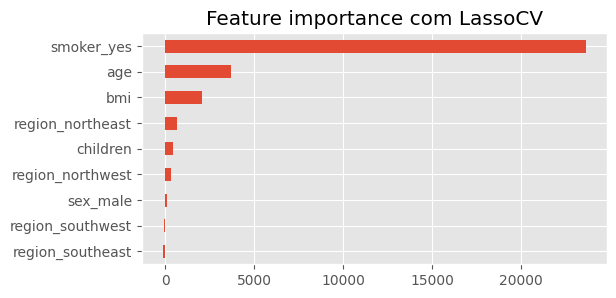

In [24]:
lasso_coef = pd.Series(lasso.coef_, index=x_train_preproc.columns)

lasso_imp_coef = lasso_coef.sort_values()

plt.rcParams['figure.figsize'] = (6, 3)
lasso_imp_coef.plot(kind="barh")
plt.title("Feature importance com LassoCV")
plt.show()

Variáveis mais influentes com LassoCV:
- tabagismo
- idade
- imc

### Ridge

In [27]:
alphas = [0.001, 0.01, 0.1, 1, 10]

ridge = RidgeCV(cv=5, alphas = alphas)

ridge.fit(x_train_preproc, y_train)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)

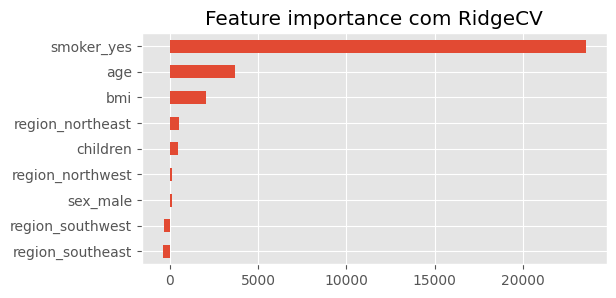

In [28]:
ridge_coef = pd.Series(ridge.coef_, index=x_train_preproc.columns)

ridge_imp_coef = ridge_coef.sort_values()

plt.rcParams['figure.figsize'] = (6, 3)
ridge_imp_coef.plot(kind="barh")
plt.title("Feature importance com RidgeCV")
plt.show()

Variáveis mais influentes com RidgeCV:
- tabagismo
- idade
- imc

### Elastic Net

In [29]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9]

elasticnet = ElasticNetCV(cv=5, alphas = alphas, l1_ratio = 0.5)

elasticnet.fit(x_train_preproc, y_train)

d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14712948.478702545, tolerance: 10209718.637070917
  model = cd_fast.enet_coordinate_descent_gram(
d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36935062.00626373, tolerance: 10581545.748589031
  model = cd_fast.enet_coordinate_descent_gram(
d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.147e+09, tolerance: 1

ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5)

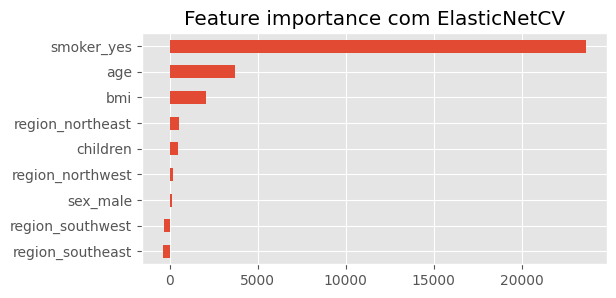

In [30]:
elasticnet_coef = pd.Series(elasticnet.coef_, index=x_train_preproc.columns)

elasticnet_imp_coef = elasticnet_coef.sort_values()

plt.rcParams['figure.figsize'] = (6, 3)
elasticnet_imp_coef.plot(kind="barh")
plt.title("Feature importance com ElasticNetCV")
plt.show()

Variáveis mais influentes com ElasticNetCV:
- tabagismo
- idade
- imc

### Permutation Importance

In [67]:
reglin_permut = LinearRegression().fit(x_train_preproc, y_train)

# calculando permutation importance
result_permut = permutation_importance(reglin_permut, x_test_preproc, y_test, n_repeats=10, random_state=0)

importances = result_permut.importances_mean
indices = np.argsort(importances)[::-1]
for f in range(x_train_preproc.shape[1]):
    print("%d. %s (%f)" % (f + 1, x_test_preproc.columns[indices[f]], importances[indices[f]]))

1. smoker_yes (1.260117)
2. age (0.159435)
3. bmi (0.060419)
4. children (0.005249)
5. region_northeast (0.001192)
6. region_southeast (0.000799)
7. region_southwest (0.000425)
8. region_northwest (0.000140)
9. sex_male (-0.000233)


Variáveis mais influentes com Permutation Importance:
- tabagismo
- idade
- imc

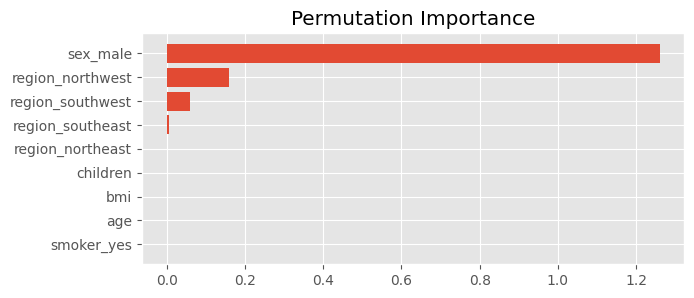

In [58]:
# Plotando feature importances
plt.figure(figsize = (7, 3))
plt.title("Permutation Importance")
plt.barh(range(x_test_preproc.shape[1]), importances[indices][::-1])
plt.yticks(range(x_test_preproc.shape[1]), x_test_preproc.columns[indices])
plt.show()

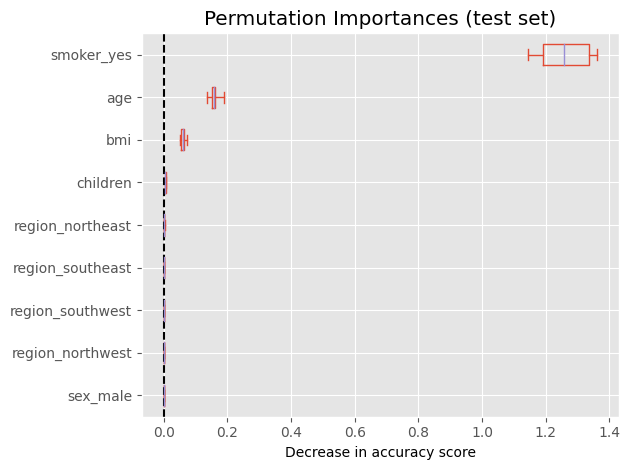

In [75]:
sorted_importances_idx = result_permut.importances_mean.argsort()
importances = pd.DataFrame(
    result_permut.importances[sorted_importances_idx].T,
    columns=x_train_preproc.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Novamente temos as mesmas 3 variáveis se destacando.

### SHapley Additive exPlanations (SHAP) 

Os recursos anteriores estão disponíveis para os modelos mais "expliáveis", aqueles que são mais facilmente interpretáveis.<br>
Porém temos modelos chamados de caixa preta, no qual não conseguimos explicar de maneira clara as decisões que o modelo tomou para chegar ao resultado, como XGBoost, redes neurais, random forest, etc.<br>
Porém temos alguns recursos como LIME (Local Interpretable Model-Agnostic Explanations) e SHAP (SHapley Additive exPlanations), este ultimo baseado em teoria dos jogos. O objetivo do SHAP atribuir uma contribuição relativa a cada variável de entrada para a saída do modelo, de modo que seja possível entender como as decisões do modelo foram tomadas.
Nesse caso a técnica foi utilizada para fins de estudo.

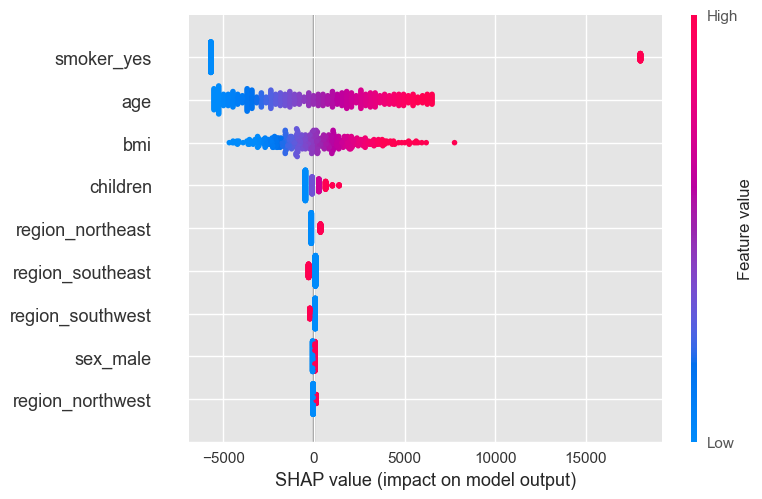

In [95]:
# Criar um objeto "explicador" usando os dados de treino
explainer = shap.Explainer(reglin0, x_train_preproc)

# Computar valores SHAP para dados de teste
shap_values = explainer(x_test_preproc)

# Plotar predição para o modelo
shap.summary_plot(shap_values, x_test_preproc, title = "Importancia das features para o modelo - SHAP")


Podemos observar pelo gráfico que o maior impacto do modelo estão, novamente, nas variáveis:
- tabagismo
- idade
- IMC

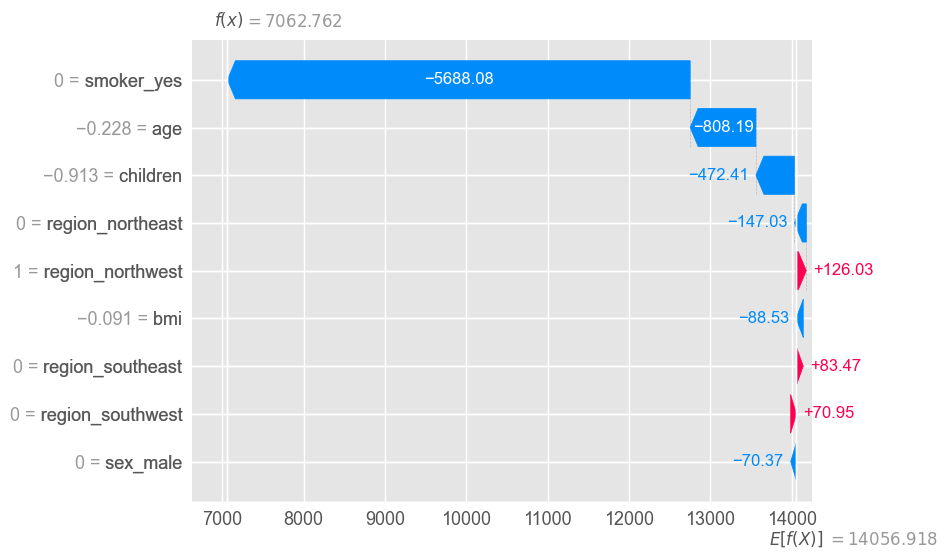

In [96]:
# Plotar valores SHAP para uma predição
shap.plots.waterfall(shap_values[1])

Podemos também fazer uma investigação em casos específicos, como observado acima selecionando uma observação.

## Otimizando modelo

Nosso modelo pode ser melhorado tanto pela retirada de features que, causam ruído e limitam a performance do modelo, quanto otimizando hiperparametros do modelo utilizado.<br>
<br>
Usaremos 2 técnicas:
- RandomSearchCV
- GridSearchCV

Nesse contexto o modelo de regressão linear não permite muitas mudanças de hiperparametros, porém podemos pesquisar se alguma transformação polinomial pode aumentar a performance do nosso modelo.

In [19]:
features_selecionadas = ['bmi', 'age', 'smoker_yes']

## Modelo com features filtradas

In [20]:
reglin1 = LinearRegression()

reglin1.fit(x_train_preproc[features_selecionadas], y_train)

y_pred_reglin1 = reglin1.predict(x_test_preproc[features_selecionadas])

In [21]:
reglin1_intercept = reglin1.intercept_.round(3)
reglin1_score = reglin1.score(x_train_preproc[features_selecionadas], y_train).round(3)
reglin1_mse = metrics.mean_squared_error(y_test, y_pred_reglin1).round(3)
reglin1_mae = metrics.mean_absolute_error(y_test, y_pred_reglin1).round(3)

print("="*46)
print("Regressão Linear - Features Filtradas")
print("="*46)
print(f'Intercepto: {reglin1_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc[features_selecionadas].columns, reglin1.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {reglin1_score}')
print("-"*46)
print(f'Erro quadrático médio: {reglin1_mse}')
print("-"*46)
print(f'Erro absoluto médio: {reglin1_mae}')
# print("-"*46)
# print(f'Tempo de execução: {round(reglin1_total, 3)}s')
print("="*46)

Regressão Linear - Features Filtradas
Intercepto: 8398.635
----------------------------------------------
Coeficientes
bmi = 1980.923
age = 3758.282
smoker_yes = 23739.488
----------------------------------------------
R²: 0.743
----------------------------------------------
Erro quadrático médio: 35822015.92
----------------------------------------------
Erro absoluto médio: 4249.469


$y =  8398.635(intercepto) + 3758.282\times(idade) + 1980.923\times(imc) + 23739.488\times(tabagista) + ε$

Utilizando o modelo com variáveis filtradas obtivemos alguma variação mas ainda não dentro do limite aceitável.

## Transformação polinomial

Há também a possibilidade de utilizarmos uma extensão da regressão linear simples que permite modelar relações não-lineares entre a variável de resposta (dependente) e a(s) variável(is) independente(s).<br>
Nesse caso teremos uma uma curva ajustada aos dados e a forma dessa curva é determinada pelo grau do polinômio usado.<br>
<br>
No exemplo abaixo vemos que a relação entre a variável x e y não é linear, desse modo a linha reta azul (modelo linear) não se adequa da melhor forma a explicar os dados (primeiro gráfico). Então foram propostas funções polinomiais de IV grau (segundo gráfico) e XV grau (terceiro gráfico). É importante notar que no segundo modelo ainda há erros, mas a linha consegue acompanhar de forma adequada as oscilações nos dados observados, já no ultimo gráfico podemos ver overfit do modelo, pois a linha azul intercepta quase que perfeitamente todos os dados do modelo. 

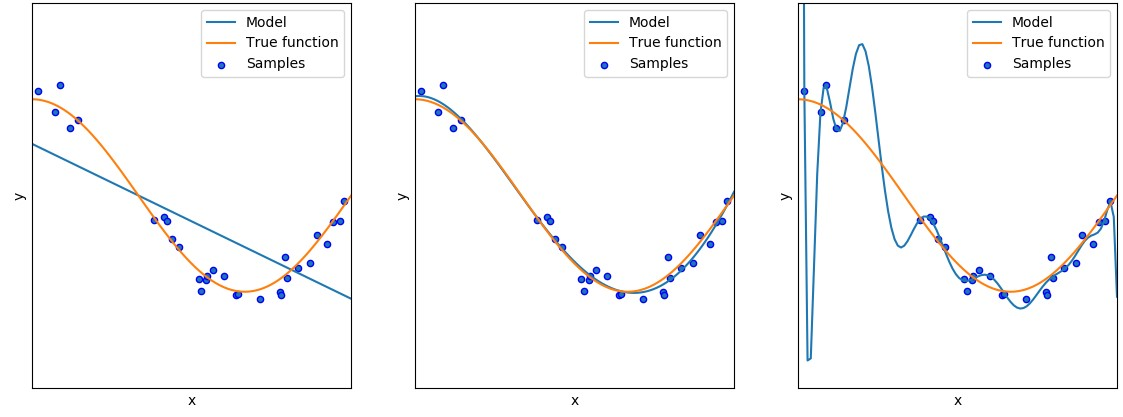

In [2]:
Image(filename='data/regpoly.jpeg')

Vamos investigar qual grau da função polinomial é mais adequado para o nosso problema

In [37]:
reglin_poly = LinearRegression()

r2_poly = []

mse_poly = []

mae_poly = []

order = [1, 2, 3, 4, 5, 6]

for n in order:
    pr = PolynomialFeatures(degree = n)
    x_train_pr = pr.fit_transform(x_train_preproc[features_selecionadas])
    x_test_pr =  pr.transform(x_test_preproc[features_selecionadas])
    reglin_poly.fit(x_train_pr, y_train)
    y_pred_poly = reglin_poly.predict(x_test_pr)
    r2_poly.append(reglin_poly.score(x_test_pr, y_test).round(3))
    mse_poly.append(metrics.mean_squared_error(y_test, y_pred_poly).round(3))
    mae_poly.append(metrics.mean_absolute_error(y_test, y_pred_poly).round(3))

In [38]:
r2 = pd.DataFrame({"ordem": order, "r²": r2_poly, "mse": mse_poly, "mae": mae_poly})
r2.set_index('ordem', inplace = True)

In [39]:
r2.sort_values(by='r²', ascending=False)

,r²,mse,mae
ordem,,,
3,0.848,22243211.719,2820.602
2,0.847,22486957.297,2843.028
5,0.838,23681478.589,2802.108
4,0.829,25042950.329,2829.045
1,0.756,35822015.920,4249.469
6,0.755,35910790.412,2928.180


Text(0.5, 1.0, 'R² por ordem de função polinomial')

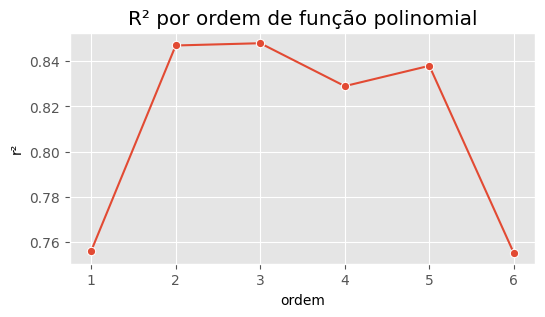

In [45]:
plt.figure(figsize = (6,3))
sns.lineplot(data=r2, x='ordem', y='r²', marker='o')
plt.title("R² por ordem de função polinomial")

Podemos ver que a função polinomial de grau III nos traz um R² maior, ou seja nosso modelo conseguiu explicar 84% da variabilidade dos gastos. Vamos utilizar essa função e averiguar os resultados.

In [46]:
reglin_poly3 = LinearRegression()

pr3 = PolynomialFeatures(degree = 3)

x_train_pr3 = pr3.fit_transform(x_train_preproc[features_selecionadas])
x_test_pr3 =  pr3.transform(x_test_preproc[features_selecionadas])

reglin_poly3.fit(x_train_pr3, y_train)

y_pred_poly3 = reglin_poly3.predict(x_test_pr3)

reglin_poly3_intercept = reglin_poly3.intercept_.round(3)
r2_poly3 = reglin_poly3.score(x_test_pr3, y_test).round(3)
mse_poly3 = metrics.mean_squared_error(y_test, y_pred_poly3).round(3)
mae_poly3 = metrics.mean_absolute_error(y_test, y_pred_poly3).round(3)

In [49]:
print("="*46)
print("Regressão Linear - Função Polinomial 3°")
print("="*46)
print(f'Intercepto: {reglin_poly3_intercept}')
print("-"*46)
print(f'R²: {r2_poly3}')
print("-"*46)
print(f'Erro quadrático médio: {mse_poly3}')
print("-"*46)
print(f'Erro absoluto médio: {mae_poly3}')
print("="*46)

Regressão Linear - Função Polinomial 3°
Intercepto: 7846.294
----------------------------------------------
R²: 0.848
----------------------------------------------
Erro quadrático médio: 22243211.719
----------------------------------------------
Erro absoluto médio: 2820.602


Com as transformações polinomiais podemos obter o maior r² de 0.84 com uma função de 3º grau, com MAE de 2820.

Conseguimos um modelo de regressão dentro do limite proposto.

# 6.Feature Engeneering

Também podemos tentar produzir novas features que podem melhorar a performance do nosso modelo.<br>
Tentaremos algumas:
- classificar em faixas o imc
- classificar em faixas a idade
- interação entre imc e idade
- interação entre numero de filhos e idade

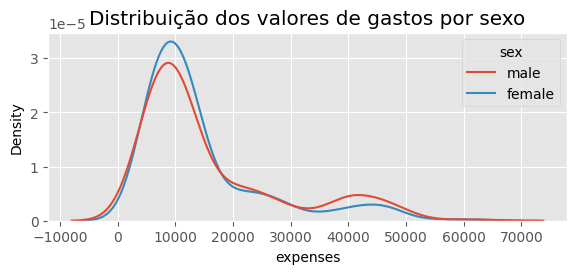

In [146]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['age'] < "yes"], x = 'expenses', hue = 'sex')

plt.title('Distribuição dos valores de gastos por sexo')

plt.tight_layout()

In [150]:
def faixa_idade(x):
    if x <= 30:
        return "< 30"
    elif 30 < x <= 50:
        return "30-50"
    else:
        return "> 50"

In [168]:
def faixa_idade2(x):
    if x <= 35:
        return "<= 35"
    else:
        return "> 35"

In [151]:
df['age_range'] = df['age'].apply(faixa_idade)

In [169]:
df['age_range2'] = df['age'].apply(faixa_idade2)

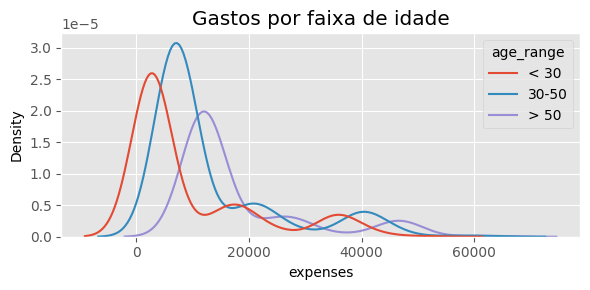

In [164]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'expenses', hue = 'age_range')

plt.title('Gastos por faixa de idade')

plt.tight_layout()

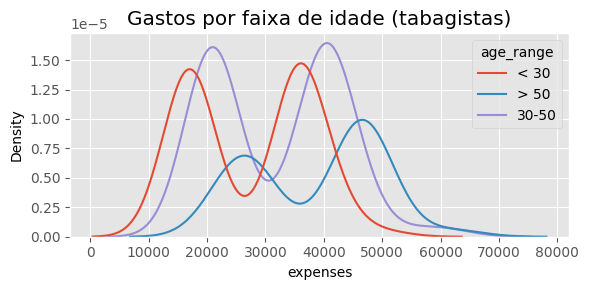

In [160]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['smoker'] == 'yes'], x = 'expenses', hue = 'age_range')

plt.title('Gastos por faixa de idade (tabagistas)')

plt.tight_layout()

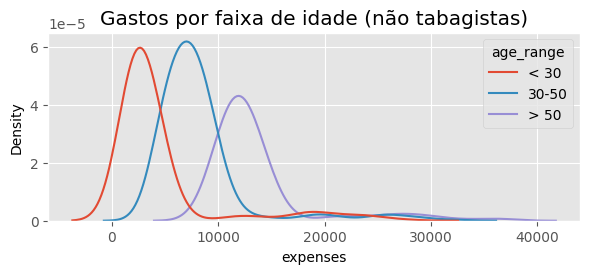

In [161]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['smoker'] == 'no'], x = 'expenses', hue = 'age_range')

plt.title('Gastos por faixa de idade (não tabagistas)')

plt.tight_layout()

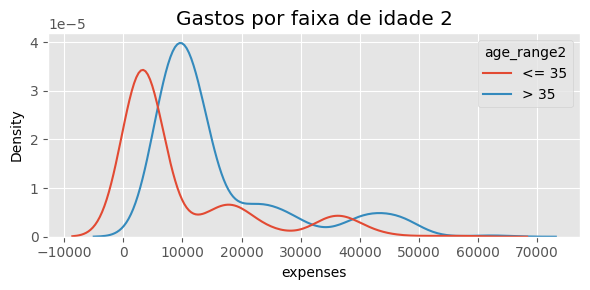

In [170]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'expenses', hue = 'age_range2')

plt.title('Gastos por faixa de idade 2')

plt.tight_layout()

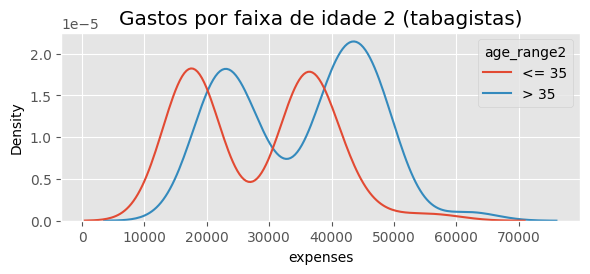

In [171]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['smoker'] == 'yes'], x = 'expenses', hue = 'age_range2')

plt.title('Gastos por faixa de idade 2 (tabagistas)')

plt.tight_layout()

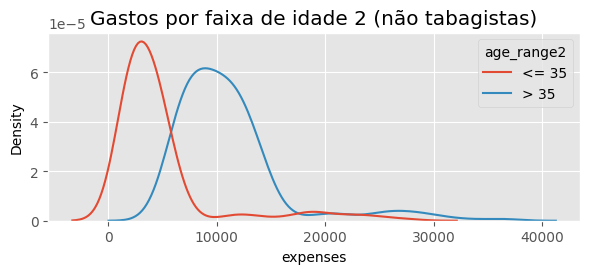

In [172]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['smoker'] == 'no'], x = 'expenses', hue = 'age_range2')

plt.title('Gastos por faixa de idade 2 (não tabagistas)')

plt.tight_layout()

In [174]:
df['bmi'].describe()

count   1338.000
mean      30.665
std        6.098
min       16.000
25%       26.300
50%       30.400
75%       34.700
max       53.100
Name: bmi, dtype: float64

In [184]:
def faixa_imc(x):
    if x < 30:
        return "< 30"
    else:
        return ">= 30"

In [185]:
df['bmi_range'] = df['bmi'].apply(faixa_imc)

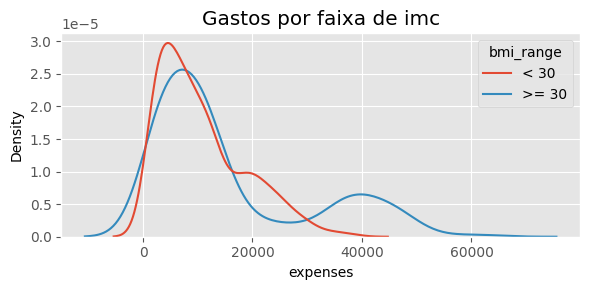

In [186]:
plt.figure(figsize=(6,3))

sns.kdeplot(df, x = 'expenses', hue = 'bmi_range')

plt.title('Gastos por faixa de imc')

plt.tight_layout()

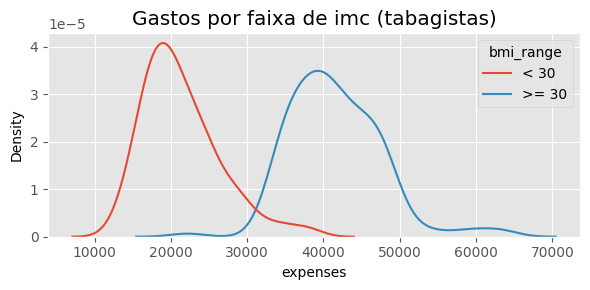

In [187]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['smoker'] == 'yes'], x = 'expenses', hue = 'bmi_range')

plt.title('Gastos por faixa de imc (tabagistas)')

plt.tight_layout()

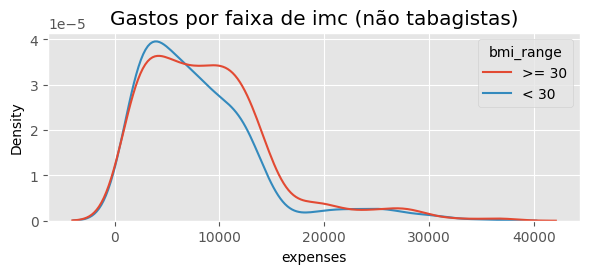

In [188]:
plt.figure(figsize=(6,3))

sns.kdeplot(df[df['smoker'] == 'no'], x = 'expenses', hue = 'bmi_range')

plt.title('Gastos por faixa de imc (não tabagistas)')

plt.tight_layout()

In [182]:
feat_engeneer = df[['smoker', 'age_range', 'bmi_range']].columns

In [183]:
feat_engeneer

Index(['smoker', 'age_range', 'bmi_range'], dtype='object')

In [194]:
df['children_cat'] = df['children'].astype('object')

In [199]:
X_fe = df.drop(['expenses', 'age_range2', 'children', 'age', 'bmi'], axis = 1)

Y_fe = df['expenses']

x_train_fe, x_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, Y_fe, test_size = 0.33, random_state = 42)

In [201]:
X_fe

,sex,smoker,region,age_range,bmi_range,children_cat
0,female,yes,southwest,< 30,< 30,0
1,male,no,southeast,< 30,>= 30,1
2,male,no,southeast,< 30,>= 30,3
3,male,no,northwest,30-50,< 30,0
4,male,no,northwest,30-50,< 30,0
...,...,...,...,...,...,...
1333,male,no,northwest,30-50,>= 30,3
1334,female,no,northeast,< 30,>= 30,0
1335,female,no,southeast,< 30,>= 30,0
1336,female,no,southwest,< 30,< 30,0


In [202]:
ohe_fe = OneHotEncoder(drop = 'if_binary')

encoding_train = ohe_fe.fit_transform(x_train_fe)

# Transform da variável categórica do teste
encoding_test = ohe_fe.transform(x_test_fe)


# Transformando dado tratado em dataframe
df_encoding_train = pd.DataFrame(encoding_train.toarray(),                             # transformando em array
                                 columns=ohe_fe.get_feature_names_out(X_fe.columns))   # resgantando nomes da variável

# Transformando dado tratado em dataframe
df_encoding_test = pd.DataFrame(encoding_test.toarray(),                               # transformando em array 
                                columns=ohe_fe.get_feature_names_out(X_fe.columns))    # resgantando nomes da variável

In [214]:
df_encoding_train = df_encoding_train[['sex_male', 'smoker_yes', 'age_range_30-50',
                                      'age_range_< 30', 'age_range_> 50', 'bmi_range_>= 30']]

df_encoding_test = df_encoding_test[['sex_male', 'smoker_yes', 'age_range_30-50',
                                    'age_range_< 30', 'age_range_> 50', 'bmi_range_>= 30']]

In [215]:
reglin_fe_inic = time.time() 

reglin_fe = LinearRegression()

reglin_fe.fit(df_encoding_train, y_train_fe)

y_pred_reglin_fe = reglin_fe.predict(df_encoding_test)

reglin_fe_fim = time.time()

reglin_fe_total = reglin_fe_fim - reglin_fe_inic

In [216]:
reglin_fe_intercept = reglin_fe.intercept_.round(3)
reglin_fe_score = reglin_fe.score(df_encoding_train, y_train).round(3)
reglin_fe_mse = metrics.mean_squared_error(y_test_fe, y_pred_reglin_fe).round(3)
reglin_fe_mae = metrics.mean_absolute_error(y_test_fe, y_pred_reglin_fe).round(3)

print("="*46)
print("Métricas para Regressão Linear - categorias")
print("="*46)
print(f'Intercepto: {reglin_fe_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(df_encoding_train.columns, reglin_fe.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {reglin_fe_score}')
print("-"*46)
print(f'Erro quadrático médio: {reglin_fe_mse}')
print("-"*46)
print(f'Erro absoluto médio: {reglin_fe_mae}')
print("-"*46)
print(f'Tempo de execução: {round(reglin_fe_total, 3)}s')
print("="*46)

Métricas para Regressão Linear - categorias
Intercepto: 2.7879592447862264e+16
----------------------------------------------
Coeficientes
sex_male = 84.112
smoker_yes = 23763.63
age_range_30-50 = -2.7879592447856396e+16
age_range_< 30 = -2.787959244786025e+16
age_range_> 50 = -2.7879592447851252e+16
bmi_range_>= 30 = 4532.336
----------------------------------------------
R²: 0.738
----------------------------------------------
Erro quadrático médio: 37680632.64
----------------------------------------------
Erro absoluto médio: 4493.493
----------------------------------------------
Tempo de execução: 0.009s


Ainda nao foi possível melhorar o modelo com Feature Engeneering, porém precisamos investigar mais abordagens (deixar algumas features categoricas e outras numéricas, talvez deixar idade numérica e imc categorica)

# 7.Conclusão

Com uma função polinomial de grau III conseguimos implementar um modelo relativamente simples para resolver o problema. Observamos também que isso é possivel com modelos mais elaborados e robustos, porrém devemos ter cuidado pois alguns modelos podem tender mais facilmente ao overfitting e são computacionalmente mais caros.
Então se tivermos um modelo simples que atenda as nossas expectativas e resolva nosso problema de forma satisfatória sem sombra de duúvidas podemos utiliza-lo ganhando também em explicabilidade e agilidade.

# Referências

- https://towardsdatascience.com/shap-explain-any-machine-learning-model-in-python-72f0bea35f7c

- https://betterdatascience.com/shap/

- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

- https://github.com/smazzanti/mrmr

- https://machinelearningmastery.com/data-preparation-without-data-leakage/

- https://towardsdatascience.com/implement-gradient-descent-in-python-9b93ed7108d1

- https://betterdatascience.com/shap/